In [3]:
%cd '/kaggle/working/'

/kaggle/working


In [1]:
!pip install vit-keras

  Obtaining dependency information for vit-keras from https://files.pythonhosted.org/packages/73/21/4af69130226fae3e937e598c1b6cd56ce008e86641034984f4cacd93c394/vit_keras-0.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for validators from https://files.pythonhosted.org/packages/8a/16/6b3d3685ba8fffafd177e5f9c0ce63bb1ceaf379283d05c7ea884acaf6ee/validators-0.28.0-py3-none-any.whl.metadata


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, LSTM, Flatten
from vit_keras import vit
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2
from keras.optimizers import Adam

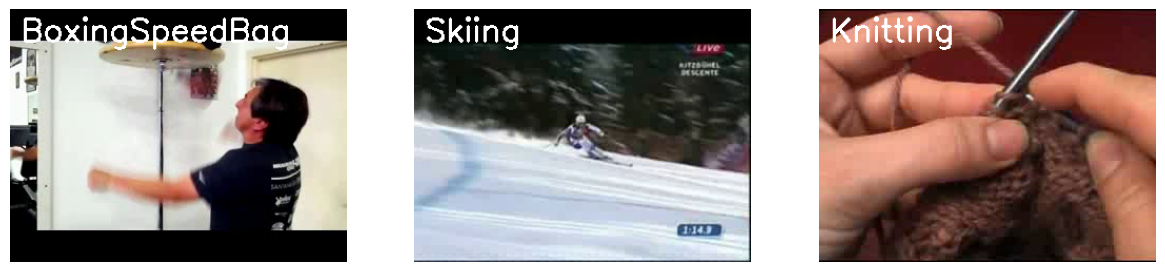

In [9]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('/kaggle/input/ucf-half/UCF-101_KTS')

random_range = random.sample(range(len(all_classes_names)), 3)

for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'/kaggle/input/ucf-half/UCF-101_KTS/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'/kaggle/input/ucf-half/UCF-101_KTS/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [10]:
import os
IMAGE_HEIGHT , IMAGE_WIDTH = 48,48

SEQUENCE_LENGTH = 25

DATASET_DIR = "/kaggle/input/ucf-half/UCF-101_KTS"



def list_folders(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

# Get the list of folders in the specified directory
CLASSES_LIST = list_folders(DATASET_DIR)
# print(CLASSES_LIST)
CLASSES_LIST = sorted(CLASSES_LIST[0:101])
# CLASSES_LIST = list_folders(DATASET_DIR)
print(CLASSES_LIST)
with open("class_labels.txt", "w") as f:
    for label in CLASSES_LIST:
        f.write(label.strip() + "\n")


print("Class labels written to class_labels.txt")


['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'HammerThrow', 'Hammering', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'P

In [11]:
def frames_extraction(video_path):

    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [12]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [13]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: ApplyEyeMakeup
Extracting Data of Class: ApplyLipstick
Extracting Data of Class: Archery
Extracting Data of Class: BabyCrawling
Extracting Data of Class: BalanceBeam
Extracting Data of Class: BandMarching
Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: BasketballDunk
Extracting Data of Class: BenchPress
Extracting Data of Class: Biking
Extracting Data of Class: Billiards
Extracting Data of Class: BlowDryHair
Extracting Data of Class: BlowingCandles
Extracting Data of Class: BodyWeightSquats
Extracting Data of Class: Bowling
Extracting Data of Class: BoxingPunchingBag
Extracting Data of Class: BoxingSpeedBag
Extracting Data of Class: BreastStroke
Extracting Data of Class: BrushingTeeth
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: CliffDiving
Extracting Data of Class: CricketBowling
Extracting Data of Class: CricketShot
Extracting Data of Class: CuttingInKitchen
Extracting Data of Class: 

In [14]:
one_hot_encoded_labels = to_categorical(labels)

In [15]:
features_train,features_test,labels_train,labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.20, shuffle = True,
                                                                            random_state = 42)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Dense, LSTM, Flatten

from tensorflow.keras.applications import ResNet101



In [17]:
from keras.layers import Attention


def create_resnet101_lstm_model():
    # ResNet-101 for spatial information
    resnet_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    model = Sequential()
    input_layer = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    reshaped_input = TimeDistributed(resnet_model)(input_layer)
    flattened_features = TimeDistributed(Flatten())(reshaped_input)
    lstm_output = LSTM(64, return_sequences=False)(flattened_features)
    output = Dense(len(CLASSES_LIST), activation='softmax')(lstm_output)
    model = Model(inputs=input_layer, outputs=output)
    model.summary()
    return model

In [18]:

convlstm_model = create_resnet101_lstm_model()

171446536/171446536 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25, 48, 48, 3)]   0         
                                                                 
 time_distributed (TimeDist  (None, 25, 2, 2, 2048)    42658176  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 25, 8192)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                2113792   
                                                                 
 dense (Dense)               (None, 101)               6565      
                                                            

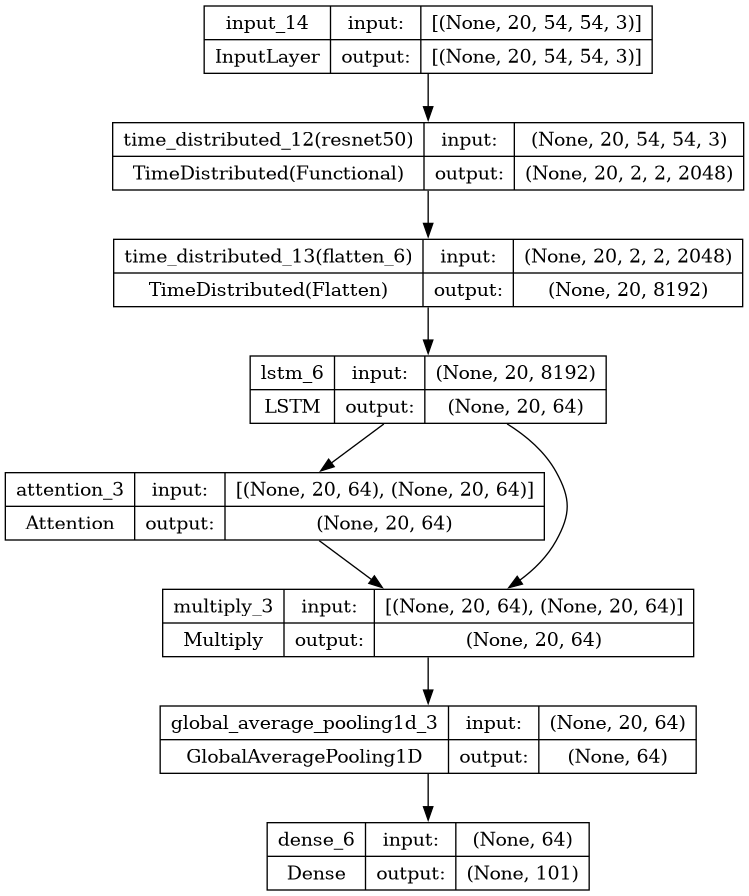

In [97]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [19]:

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights = True)

optimizer = Adam(learning_rate=0.00001)#, clipnorm=1.0)  # Adjust the learning rate and clip norm as needed)
# learning_rate=0.00001
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 32,
                                                     shuffle = True,
                                                     callbacks = [early_stopping_callback])

Epoch 1/100
128/128 [==============================] - 163s 633ms/step - loss: 4.6147 - accuracy: 0.0154
Epoch 2/100
128/128 [==============================] - 77s 602ms/step - loss: 4.3885 - accuracy: 0.0737
Epoch 3/100
128/128 [==============================] - 77s 601ms/step - loss: 4.1261 - accuracy: 0.1751
Epoch 4/100
128/128 [==============================] - 77s 601ms/step - loss: 3.8040 - accuracy: 0.3156
Epoch 5/100
128/128 [==============================] - 77s 601ms/step - loss: 3.4802 - accuracy: 0.4349
Epoch 6/100
128/128 [==============================] - 77s 601ms/step - loss: 3.1683 - accuracy: 0.5500
Epoch 7/100
128/128 [==============================] - 77s 601ms/step - loss: 2.8849 - accuracy: 0.6391
Epoch 8/100
128/128 [==============================] - 77s 600ms/step - loss: 2.6377 - accuracy: 0.7064
Epoch 9/100
128/128 [==============================] - 77s 601ms/step - loss: 2.3975 - accuracy: 0.7752
Epoch 10/100
128/128 [==============================] - 77s 601

In [44]:
def predict_video_activity(model, video_path, sequence_length=25, image_height=48, image_width=48):
    # Open video file
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        resized_frame = cv2.resize(frame, (image_height, image_width))  # Resize frame
        frames.append(resized_frame)
    cap.release()

    # Convert frames to numpy array and normalize pixel values
    frames = np.array(frames) / 255.0

    # Ensure the number of frames is at least the sequence length
    if len(frames) < sequence_length:
        return "Insufficient frames for prediction"

    # Select the last sequence_length frames
    frames = frames[-sequence_length:]

    # Reshape the frames to fit the model input shape
    frames = frames.reshape(1, sequence_length, image_height, image_width, 3)

    # Make predictions using the model
    predictions = model.predict(frames)

    # Get the predicted class index
    predicted_index = np.argmax(predictions)
    
    # Map index to class name
    predicted_class = CLASSES_LIST[predicted_index]

    return predicted_class

# Example usage:
video_path = '/kaggle/input/arceth/v_Archery_g02_c01.avi'  # Change this to your video file path
predicted_activity = predict_video_activity(convlstm_model, video_path)
print("Predicted Activity:", predicted_activity)


1/1 [==============================] - 0s 24ms/step
Predicted Activity: Archery
